In [1]:
%load_ext tensorboard
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-11-14 21:34:41.496210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 21:34:41.524091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 21:34:41.524447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
from pandas import read_parquet
from data import file

data_train = read_parquet(file.news_articles_cleaned_train)
data_test = read_parquet(file.news_articles_cleaned_test)

In [3]:
from preprocessing.categorical import binarizer

X_train = data_train.text_tokenized_stemmed
y_train = data_train.label

X_test = data_test.text_tokenized_stemmed
y_test = data_test.label



batch_size = 32

y_train = data_train.label
label_binarizer = binarizer(y_train)

x_train = data_train['text_stem']
y_train_bin = label_binarizer.transform(y_train)

x_test = data_test['text_stem']
y_test_bin = label_binarizer.transform(y_test)

train_input = tf.data.Dataset.from_tensor_slices((x_train, y_train_bin)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_input = tf.data.Dataset.from_tensor_slices((x_test, y_test_bin)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_input


2021-11-14 21:34:43.153616: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-14 21:34:43.154518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 21:34:43.154941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 21:34:43.155248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

<PrefetchDataset shapes: ((None,), (None, 9)), types: (tf.string, tf.int64)>

In [4]:
from models import rnn
model, model_name = rnn.build_model(X_train, y_train, len(label_binarizer.classes_), rnn_num_layers = 1)
model.summary()

Median sequence length:       : 173
Percentil                     : 0.98)
Cutoff sequence length        : 589
Max sequence length           : 1699
Embedding length              : 589
Vocabulary length             : 162207


Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         48662100  
_________________________________________________________________
bidirectional_lstm_0 (Bidire (None, None, 64)          85248     
_________________________________________________________________
global_max_pool (GlobalMaxPo (None, 64)                0         
_________________________________________________________________
prediction (Dense)           (None, 9)                 585       
Total params: 48,747,933
Trainable params: 85,833
Non-trainable params: 48,662,100
_________________________________________________________________


In [5]:
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

learning_rate=0.02
model_metric = ["accuracy"]
loss_function = CategoricalCrossentropy()
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss=loss_function, optimizer=optimizer, metrics=model_metric)

In [6]:
callbacks = []
history = model.fit(train_input, validation_data=test_input, callbacks=callbacks, epochs=5)

Epoch 1/5


2021-11-14 21:36:04.625547: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-14 21:36:06.416178: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


289/289 [==============================] - 81s 243ms/step - loss: 1.6639 - accuracy: 0.4224 - val_loss: 1.2758 - val_accuracy: 0.5749
Epoch 2/5
289/289 [==============================] - 68s 237ms/step - loss: 1.1499 - accuracy: 0.6106 - val_loss: 1.1377 - val_accuracy: 0.6313
Epoch 3/5
289/289 [==============================] - 67s 233ms/step - loss: 0.9413 - accuracy: 0.6885 - val_loss: 1.0827 - val_accuracy: 0.6430
Epoch 4/5
289/289 [==============================] - 67s 231ms/step - loss: 0.7933 - accuracy: 0.7383 - val_loss: 1.0572 - val_accuracy: 0.6469
Epoch 5/5
289/289 [==============================] - 67s 231ms/step - loss: 0.6609 - accuracy: 0.7797 - val_loss: 1.0554 - val_accuracy: 0.6751


In [7]:
y_predict = label_binarizer.inverse_transform(model.predict(x_test[0:100]))

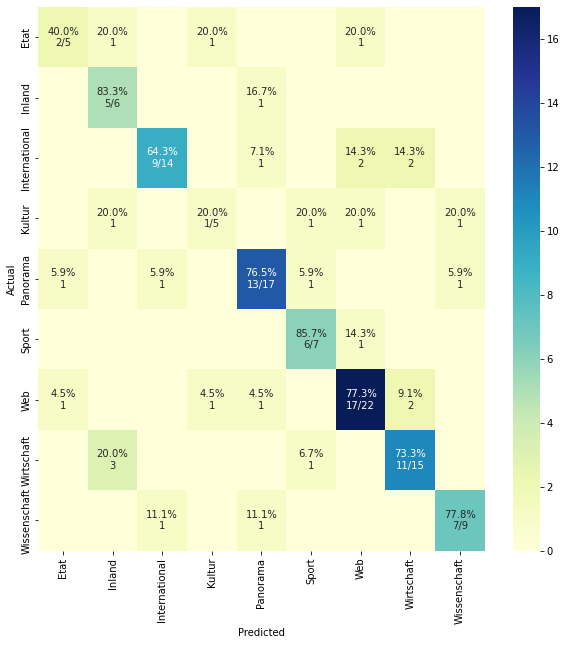

In [8]:
from reporting.evaluation import plot_confusion_matrix
plot_confusion_matrix(y_test[0:100], y_predict)

In [9]:
import time
bucket="fhnw-nlp-models"
region="us"
model_name="rnn_layers-1_units-32"
ts = time.strftime("%Y%m%d-%H%M%S")
export_path = f"gs://{bucket}-{region}/{model_name}_{ts}"

In [10]:
# model.save(export_path)

2021-11-14 21:42:07.978697: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://fhnw-nlp-models-us/rnn_layers-1_units-32_20211114-214153/assets


INFO:tensorflow:Assets written to: gs://fhnw-nlp-models-us/rnn_layers-1_units-32_20211114-214153/assets
